### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per kilometer fuel and other costs
R = 9 # per kilometer revenue from a passenger

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [5]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [6]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            #print("Action", action_list)
            action_index = env.action_space.index(action_list)
            #print("Action index", action_index)
            Q = prediction[0][action_index]
            #print("Q", Q)
            states_track[state][action].append(Q)          

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
state_size = m+t+d
action_size = m*(m-1) + 1 

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = m+t+d
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_encod_arch1(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
            
        return action, epsilon   
        

    def append_sample(self, state, action, reward, next_state, terminal_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  

        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminal_states = [], [], []

        
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            update_input[i] = env.state_encod_arch1(state)
            update_output[i] = env.state_encod_arch1(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                #print(True)
                target[i][actions[i]] = rewards[i]
                
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

                
                
    def load(self, name):
        self.model.load_weights(name)
        
                    
    def save(self, name):
        self.model.save_weights(name)

    
    
                # Write your code from here
                # 1. Predict the target from earlier model
                
                
                # 2. Get the target for the Q-network
                
                
                #3. Update your 'update_output' and 'update_input' batch

                
                
        # 4. Fit your model and track the loss values

In [10]:
Episodes = 40000

### DQN block

In [11]:
# Importing the environment
from Env import CabDriver

In [12]:
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



episode: 0   score: 129.0   memory length: 130   epsilon: 1.0
episode: 25   score: -198.0   memory length: 2000   epsilon: 0.9925280548938579
episode: 50   score: -207.0   memory length: 2000   epsilon: 0.9851119397519432
episode: 75   score: -79.0   memory length: 2000   epsilon: 0.9777512374158239
episode: 100   score: -226.0   memory length: 2000   epsilon: 0.9704455338440529
episode: 125   score: -496.0   memory length: 2000   epsilon: 0.9631944180888776
episode: 150   score: 91.0   memory length: 2000   epsilon: 0.9559974822731252
episode: 175   score: 5.0   memory length: 2000   epsilon: 0.948854321567258
episode: 200   score: -54.0   memory length: 2000   epsilon: 0.9417645341666034
episode: 225   score: -119.0   memory length: 2000   epsilon: 0.9347277212687504
episode: 250   score: 130.0   memory length: 2000   epsilon: 0.927743487051118
episode: 275   score: -147.0   memory length: 2000   epsilon: 0.9208114386486902
episode: 300   score: -11.0   memory length: 2000   epsilon

episode: 2500   score: 534.0   memory length: 2000   epsilon: 0.47236655801734917
episode: 2525   score: 254.0   memory length: 2000   epsilon: 0.4688370610652907
episode: 2550   score: 431.0   memory length: 2000   epsilon: 0.4653339363209741
episode: 2575   score: 412.0   memory length: 2000   epsilon: 0.46185698673270864
episode: 2600   score: 812.0   memory length: 2000   epsilon: 0.45840601672116343
episode: 2625   score: 370.0   memory length: 2000   epsilon: 0.4549808321683652
episode: 2650   score: 155.0   memory length: 2000   epsilon: 0.4515812404067799
episode: 2675   score: 740.0   memory length: 2000   epsilon: 0.4482070502084744
episode: 2700   score: 628.0   memory length: 2000   epsilon: 0.4448580717743605
episode: 2725   score: 785.0   memory length: 2000   epsilon: 0.4415341167235181
episode: 2750   score: 842.0   memory length: 2000   epsilon: 0.4382349980825993
episode: 2775   score: 557.0   memory length: 2000   epsilon: 0.4349605302753106
episode: 2800   score: 55

episode: 5025   score: 839.0   memory length: 2000   epsilon: 0.22146295160897447
episode: 5050   score: 1323.0   memory length: 2000   epsilon: 0.21980819264967988
episode: 5075   score: 1112.0   memory length: 2000   epsilon: 0.21816579795861663
episode: 5100   score: 893.0   memory length: 2000   epsilon: 0.21653567515065042
episode: 5125   score: 913.0   memory length: 2000   epsilon: 0.21491773253094335
episode: 5150   score: 1145.0   memory length: 2000   epsilon: 0.2133118790897965
episode: 5175   score: 1330.0   memory length: 2000   epsilon: 0.21171802449753047
episode: 5200   score: 1019.0   memory length: 2000   epsilon: 0.21013607909940404
episode: 5225   score: 1134.0   memory length: 2000   epsilon: 0.20856595391057153
episode: 5250   score: 1404.0   memory length: 2000   epsilon: 0.2070075606110771
episode: 5275   score: 925.0   memory length: 2000   epsilon: 0.20546081154088675
episode: 5300   score: 1080.0   memory length: 2000   epsilon: 0.20392561969495734
episode: 5

episode: 7525   score: 1127.0   memory length: 2000   epsilon: 0.10461169628771591
episode: 7550   score: 1053.0   memory length: 2000   epsilon: 0.10383004350249662
episode: 7575   score: 878.0   memory length: 2000   epsilon: 0.10305423118403892
episode: 7600   score: 911.0   memory length: 2000   epsilon: 0.1022842156926954
episode: 7625   score: 1460.0   memory length: 2000   epsilon: 0.10151995371489163
episode: 7650   score: 1138.0   memory length: 2000   epsilon: 0.10076140226068979
episode: 7675   score: 1267.0   memory length: 2000   epsilon: 0.10000851866137064
episode: 7700   score: 1335.0   memory length: 2000   epsilon: 0.09926126056703317
episode: 7725   score: 1258.0   memory length: 2000   epsilon: 0.0985195859442125
episode: 7750   score: 1368.0   memory length: 2000   epsilon: 0.09778345307351563
episode: 7775   score: 1062.0   memory length: 2000   epsilon: 0.09705282054727445
episode: 7800   score: 1044.0   memory length: 2000   epsilon: 0.09632764726721664
episode:

episode: 10000   score: 1300.0   memory length: 2000   epsilon: 0.04978707786999328


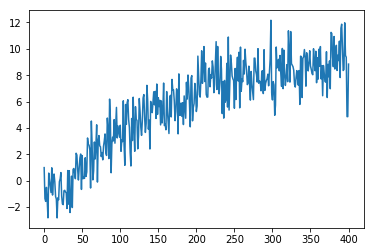

episode: 10025   score: 1622.0   memory length: 2000   epsilon: 0.04941507162815284
episode: 10050   score: 1492.0   memory length: 2000   epsilon: 0.049045844996558396
episode: 10075   score: 1503.0   memory length: 2000   epsilon: 0.04867937720611454
episode: 10100   score: 1386.0   memory length: 2000   epsilon: 0.04831564764291141
episode: 10125   score: 1448.0   memory length: 2000   epsilon: 0.04795463584706521
episode: 10150   score: 1422.0   memory length: 2000   epsilon: 0.047596321511567195
episode: 10175   score: 1512.0   memory length: 2000   epsilon: 0.04724068448114156
episode: 10200   score: 1244.0   memory length: 2000   epsilon: 0.04688770475111156
episode: 10225   score: 1448.0   memory length: 2000   epsilon: 0.04653736246627427
episode: 10250   score: 1878.0   memory length: 2000   epsilon: 0.04618963791978384
episode: 10275   score: 1048.0   memory length: 2000   epsilon: 0.045844511552042826
episode: 10300   score: 1206.0   memory length: 2000   epsilon: 0.0455019

episode: 12475   score: 1828.0   memory length: 2000   epsilon: 0.023694801806280107
episode: 12500   score: 1282.0   memory length: 2000   epsilon: 0.023517755620831658
episode: 12525   score: 1682.0   memory length: 2000   epsilon: 0.02334203231477535
episode: 12550   score: 1530.0   memory length: 2000   epsilon: 0.02316762200362891
episode: 12575   score: 1603.0   memory length: 2000   epsilon: 0.022994514876766323
episode: 12600   score: 1566.0   memory length: 2000   epsilon: 0.022822701196866066
episode: 12625   score: 1737.0   memory length: 2000   epsilon: 0.022652171299363356
episode: 12650   score: 1576.0   memory length: 2000   epsilon: 0.022482915591906485
episode: 12675   score: 1636.0   memory length: 2000   epsilon: 0.022314924553817266
episode: 12700   score: 1701.0   memory length: 2000   epsilon: 0.022148188735555536
episode: 12725   score: 1730.0   memory length: 2000   epsilon: 0.021982698758187546
episode: 12750   score: 1622.0   memory length: 2000   epsilon: 0.0

episode: 14900   score: 1165.0   memory length: 2000   epsilon: 0.011447325736032552
episode: 14925   score: 1363.0   memory length: 2000   epsilon: 0.0113617920203849
episode: 14950   score: 1157.0   memory length: 2000   epsilon: 0.011276897407971692
episode: 14975   score: 1426.0   memory length: 2000   epsilon: 0.011192637123448576
episode: 15000   score: 1285.0   memory length: 2000   epsilon: 0.01110900642715234
episode: 15025   score: 1397.0   memory length: 2000   epsilon: 0.011026000614834278
episode: 15050   score: 1449.0   memory length: 2000   epsilon: 0.010943615017395538
episode: 15075   score: 1324.0   memory length: 2000   epsilon: 0.010861845000624554
episode: 15100   score: 1529.0   memory length: 2000   epsilon: 0.01078068596493633
episode: 15125   score: 1390.0   memory length: 2000   epsilon: 0.010700133345113693
episode: 15150   score: 1365.0   memory length: 2000   epsilon: 0.010620182610050542
episode: 15175   score: 1241.0   memory length: 2000   epsilon: 0.010

episode: 17325   score: 1871.0   memory length: 2000   epsilon: 0.0055303830301477955
episode: 17350   score: 1561.0   memory length: 2000   epsilon: 0.005489060386036819
episode: 17375   score: 1755.0   memory length: 2000   epsilon: 0.005448046502457364
episode: 17400   score: 1438.0   memory length: 2000   epsilon: 0.005407339072367668
episode: 17425   score: 1777.0   memory length: 2000   epsilon: 0.005366935805964061
episode: 17450   score: 1681.0   memory length: 2000   epsilon: 0.005326834430552145
episode: 17475   score: 1556.0   memory length: 2000   epsilon: 0.005287032690418984
episode: 17500   score: 1699.0   memory length: 2000   epsilon: 0.005247528346706205
episode: 17525   score: 1707.0   memory length: 2000   epsilon: 0.00520831917728405
episode: 17550   score: 1629.0   memory length: 2000   epsilon: 0.005169402976626403
episode: 17575   score: 1710.0   memory length: 2000   epsilon: 0.005130777555686718
episode: 17600   score: 1557.0   memory length: 2000   epsilon: 0

episode: 19750   score: 1989.0   memory length: 2000   epsilon: 0.0026718176584813735
episode: 19775   score: 1782.0   memory length: 2000   epsilon: 0.002651854058123396
episode: 19800   score: 1948.0   memory length: 2000   epsilon: 0.002632039624692904
episode: 19825   score: 1768.0   memory length: 2000   epsilon: 0.002612373243622794
episode: 19850   score: 1664.0   memory length: 2000   epsilon: 0.002592853808673948
episode: 19875   score: 1640.0   memory length: 2000   epsilon: 0.0025734802218729995
episode: 19900   score: 1494.0   memory length: 2000   epsilon: 0.002554251393450584
episode: 19925   score: 2025.0   memory length: 2000   epsilon: 0.0025351662417800354
episode: 19950   score: 1678.0   memory length: 2000   epsilon: 0.0025162236933165354
episode: 19975   score: 1800.0   memory length: 2000   epsilon: 0.00249742268253674
episode: 20000   score: 1593.0   memory length: 2000   epsilon: 0.0024787621518788387


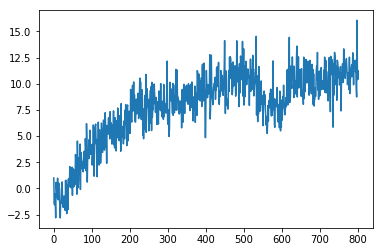

episode: 20025   score: 1764.0   memory length: 2000   epsilon: 0.0024602410516830564
episode: 20050   score: 1651.0   memory length: 2000   epsilon: 0.002441858340132627
episode: 20075   score: 1629.0   memory length: 2000   epsilon: 0.0024236129831951793
episode: 20100   score: 1889.0   memory length: 2000   epsilon: 0.0024055039545645717
episode: 20125   score: 1620.0   memory length: 2000   epsilon: 0.0023875302356031708
episode: 20150   score: 1646.0   memory length: 2000   epsilon: 0.0023696908152845476
episode: 20175   score: 1588.0   memory length: 2000   epsilon: 0.002351984690136601
episode: 20200   score: 1660.0   memory length: 2000   epsilon: 0.002334410864185126
episode: 20225   score: 1772.0   memory length: 2000   epsilon: 0.0023169683488977783
episode: 20250   score: 1822.0   memory length: 2000   epsilon: 0.002299656163128476
episode: 20275   score: 1559.0   memory length: 2000   epsilon: 0.002282473333062201
episode: 20300   score: 1644.0   memory length: 2000   epsi

episode: 22425   score: 1802.0   memory length: 2000   epsilon: 0.0011975330145895017
episode: 22450   score: 1722.0   memory length: 2000   epsilon: 0.0011885851882716685
episode: 22475   score: 1793.0   memory length: 2000   epsilon: 0.00117970421962157
episode: 22500   score: 1617.0   memory length: 2000   epsilon: 0.0011708896090823792
episode: 22525   score: 1856.0   memory length: 2000   epsilon: 0.0011621408608299267
episode: 22550   score: 1801.0   memory length: 2000   epsilon: 0.0011534574827448177
episode: 22575   score: 1601.0   memory length: 2000   epsilon: 0.0011448389863847463
episode: 22600   score: 1670.0   memory length: 2000   epsilon: 0.0011362848869570178
episode: 22625   score: 1512.0   memory length: 2000   epsilon: 0.0011277947032912851
episode: 22650   score: 1732.0   memory length: 2000   epsilon: 0.0011193679578124789
episode: 22675   score: 1674.0   memory length: 2000   epsilon: 0.0011110041765139426
episode: 22700   score: 1872.0   memory length: 2000   e

episode: 24825   score: 1602.0   memory length: 2000   epsilon: 0.0005829070289154257
episode: 24850   score: 1629.0   memory length: 2000   epsilon: 0.0005785516542692829
episode: 24875   score: 1818.0   memory length: 2000   epsilon: 0.0005742288227437377
episode: 24900   score: 1788.0   memory length: 2000   epsilon: 0.0005699382911783775
episode: 24925   score: 1500.0   memory length: 2000   epsilon: 0.0005656798182296708
episode: 24950   score: 1593.0   memory length: 2000   epsilon: 0.0005614531643573906
episode: 24975   score: 1671.0   memory length: 2000   epsilon: 0.0005572580918111427
episode: 25000   score: 1775.0   memory length: 2000   epsilon: 0.0005530943646169904
episode: 25025   score: 1575.0   memory length: 2000   epsilon: 0.0005489617485641804
episode: 25050   score: 1880.0   memory length: 2000   epsilon: 0.0005448600111919706
episode: 25075   score: 1717.0   memory length: 2000   epsilon: 0.0005407889217765527
episode: 25100   score: 1962.0   memory length: 2000  

episode: 27200   score: 1715.0   memory length: 2000   epsilon: 0.0002858723919387847
episode: 27225   score: 1701.0   memory length: 2000   epsilon: 0.00028373644381694856
episode: 27250   score: 1796.0   memory length: 2000   epsilon: 0.00028161645538238745
episode: 27275   score: 1476.0   memory length: 2000   epsilon: 0.00027951230738519346
episode: 27300   score: 1453.0   memory length: 2000   epsilon: 0.00027742388146648683
episode: 27325   score: 1687.0   memory length: 2000   epsilon: 0.0002753510601517592
episode: 27350   score: 1604.0   memory length: 2000   epsilon: 0.00027329372684426487
episode: 27375   score: 1669.0   memory length: 2000   epsilon: 0.00027125176581846335
episode: 27400   score: 1919.0   memory length: 2000   epsilon: 0.00026922506221350767
episode: 27425   score: 1921.0   memory length: 2000   epsilon: 0.000267213502026786
episode: 27450   score: 1638.0   memory length: 2000   epsilon: 0.00026521697210750753
episode: 27475   score: 1727.0   memory length:

episode: 29575   score: 1832.0   memory length: 2000   epsilon: 0.00014020166863315775
episode: 29600   score: 1951.0   memory length: 2000   epsilon: 0.00013915416417031724
episode: 29625   score: 1754.0   memory length: 2000   epsilon: 0.00013811448660339977
episode: 29650   score: 1725.0   memory length: 2000   epsilon: 0.0001370825774502681
episode: 29675   score: 1590.0   memory length: 2000   epsilon: 0.00013605837866576028
episode: 29700   score: 1521.0   memory length: 2000   epsilon: 0.0001350418326384248
episode: 29725   score: 1739.0   memory length: 2000   epsilon: 0.0001340328821872792
episode: 29750   score: 1657.0   memory length: 2000   epsilon: 0.00013303147055859473
episode: 29775   score: 1535.0   memory length: 2000   epsilon: 0.00013203754142270327
episode: 29800   score: 1908.0   memory length: 2000   epsilon: 0.00013105103887082887
episode: 29825   score: 1871.0   memory length: 2000   epsilon: 0.00013007190741194286
episode: 29850   score: 1548.0   memory length

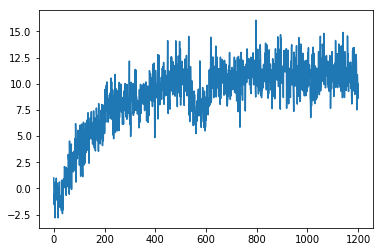

episode: 30025   score: 1531.0   memory length: 2000   epsilon: 0.00012249769157088625
episode: 30050   score: 1600.0   memory length: 2000   epsilon: 0.00012158247025413828
episode: 30075   score: 1776.0   memory length: 2000   epsilon: 0.0001206740874208974
episode: 30100   score: 1771.0   memory length: 2000   epsilon: 0.00011977249197438974
episode: 30125   score: 1656.0   memory length: 2000   epsilon: 0.00011887763319963368
episode: 30150   score: 1808.0   memory length: 2000   epsilon: 0.00011798946076058723
episode: 30175   score: 1692.0   memory length: 2000   epsilon: 0.00011710792469731669
episode: 30200   score: 1656.0   memory length: 2000   epsilon: 0.00011623297542318564
episode: 30225   score: 1901.0   memory length: 2000   epsilon: 0.00011536456372206695
episode: 30250   score: 1745.0   memory length: 2000   epsilon: 0.00011450264074557343
episode: 30275   score: 1799.0   memory length: 2000   epsilon: 0.0001136471580103104
episode: 30300   score: 1995.0   memory lengt

episode: 32425   score: 2059.0   memory length: 2000   epsilon: 5.9631160199458054e-05
episode: 32450   score: 1666.0   memory length: 2000   epsilon: 5.918567415882832e-05
episode: 32475   score: 1931.0   memory length: 2000   epsilon: 5.874351676547302e-05
episode: 32500   score: 1629.0   memory length: 2000   epsilon: 5.830466314792217e-05
episode: 32525   score: 1599.0   memory length: 2000   epsilon: 5.786908862054419e-05
episode: 32550   score: 1789.0   memory length: 2000   epsilon: 5.743676868215686e-05
episode: 32575   score: 1859.0   memory length: 2000   epsilon: 5.700767901464975e-05
episode: 32600   score: 1321.0   memory length: 2000   epsilon: 5.658179548161592e-05
episode: 32625   score: 1873.0   memory length: 2000   epsilon: 5.615909412699436e-05
episode: 32650   score: 1472.0   memory length: 2000   epsilon: 5.57395511737224e-05
episode: 32675   score: 1660.0   memory length: 2000   epsilon: 5.5323143022398414e-05
episode: 32700   score: 1948.0   memory length: 2000 

episode: 34800   score: 1652.0   memory length: 2000   epsilon: 2.9249207989264667e-05
episode: 34825   score: 1682.0   memory length: 2000   epsilon: 2.9030734230037065e-05
episode: 34850   score: 1747.0   memory length: 2000   epsilon: 2.8813892894761916e-05
episode: 34875   score: 1832.0   memory length: 2000   epsilon: 2.859867178605684e-05
episode: 34900   score: 1807.0   memory length: 2000   epsilon: 2.8385058797677773e-05
episode: 34925   score: 1982.0   memory length: 2000   epsilon: 2.8173041913837794e-05
episode: 34950   score: 1629.0   memory length: 2000   epsilon: 2.796260920853128e-05
episode: 34975   score: 1935.0   memory length: 2000   epsilon: 2.775374884486308e-05
episode: 35000   score: 1478.0   memory length: 2000   epsilon: 2.754644907438271e-05
episode: 35025   score: 1770.0   memory length: 2000   epsilon: 2.734069823642333e-05
episode: 35050   score: 1583.0   memory length: 2000   epsilon: 2.7136484757446097e-05
episode: 35075   score: 1867.0   memory length: 

episode: 37175   score: 1591.0   memory length: 2000   epsilon: 1.4349393614270019e-05
episode: 37200   score: 1838.0   memory length: 2000   epsilon: 1.424225045125742e-05
episode: 37225   score: 1715.0   memory length: 2000   epsilon: 1.4135907856085326e-05
episode: 37250   score: 1701.0   memory length: 2000   epsilon: 1.4030359846954752e-05
episode: 37275   score: 1548.0   memory length: 2000   epsilon: 1.392560048676235e-05
episode: 37300   score: 1593.0   memory length: 2000   epsilon: 1.3821623882766487e-05
episode: 37325   score: 1698.0   memory length: 2000   epsilon: 1.3718424186255772e-05
episode: 37350   score: 1901.0   memory length: 2000   epsilon: 1.3615995592220093e-05
episode: 37375   score: 1763.0   memory length: 2000   epsilon: 1.3514332339023976e-05
episode: 37400   score: 1943.0   memory length: 2000   epsilon: 1.341342870808265e-05
episode: 37425   score: 1993.0   memory length: 2000   epsilon: 1.3313279023540266e-05
episode: 37450   score: 1770.0   memory length

episode: 39550   score: 1548.0   memory length: 2000   epsilon: 7.042276978927131e-06
episode: 39575   score: 1521.0   memory length: 2000   epsilon: 6.989732190843951e-06
episode: 39600   score: 1619.0   memory length: 2000   epsilon: 6.937580014536869e-06
episode: 39625   score: 1665.0   memory length: 2000   epsilon: 6.8858175164322145e-06
episode: 39650   score: 1674.0   memory length: 2000   epsilon: 6.834441784875824e-06
episode: 39675   score: 1854.0   memory length: 2000   epsilon: 6.78344992996926e-06
episode: 39700   score: 1791.0   memory length: 2000   epsilon: 6.732839083407218e-06
episode: 39725   score: 1662.0   memory length: 2000   epsilon: 6.682606398316244e-06
episode: 39750   score: 1458.0   memory length: 2000   epsilon: 6.632749049094556e-06
episode: 39775   score: 1662.0   memory length: 2000   epsilon: 6.583264231253117e-06
episode: 39800   score: 1819.0   memory length: 2000   epsilon: 6.534149161257874e-06
episode: 39825   score: 1601.0   memory length: 2000  

In [13]:
# Write code here
# Call the environment
# Call all the initialised variables of the environment
    
Episodes = 40000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        

        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

    if episode % 25 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        

              
# Write your code here
# 1. Pick epsilon-greedy action from possible actions for the current state
# 2. Evaluate your reward and next state
# 3. Append the experience to the memory
# 4. Train the model by calling function agent.train_model
# 5. Keep a track of rewards, Q-values, loss
        

### Plotting results

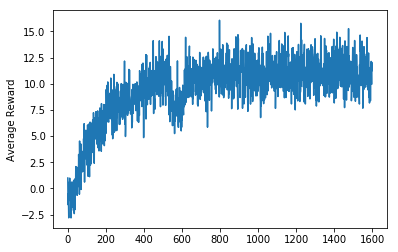

In [14]:
# Plotting average rewards
# x-values = 40000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

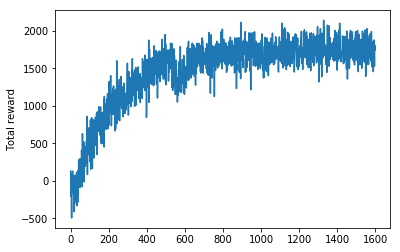

In [15]:
# Plotting total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()

### Tracking Convergence

<function matplotlib.pyplot.show(*args, **kw)>

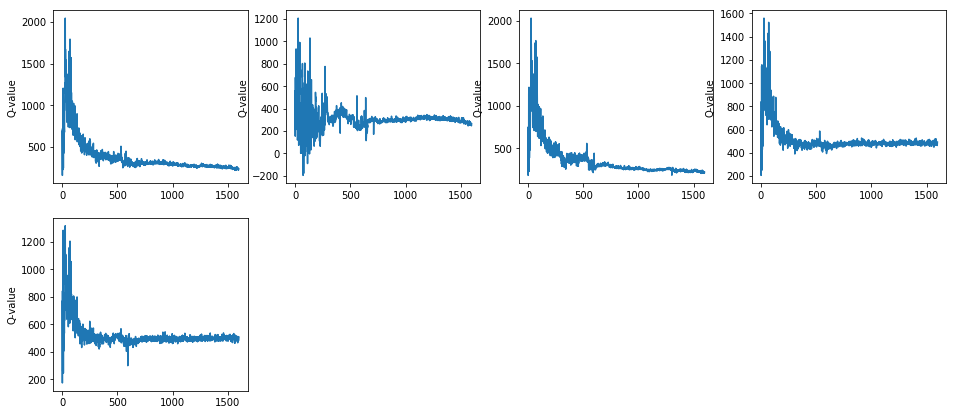

In [16]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(len(states_track[(3,0,2)][(3,1)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(1,6,3)][(2,3)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(2,2,2)][(3,2)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(3,10,6)][(3,4)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(0,20,3)][(1,4)])))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)]))
plt.ylabel("Q-value")
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

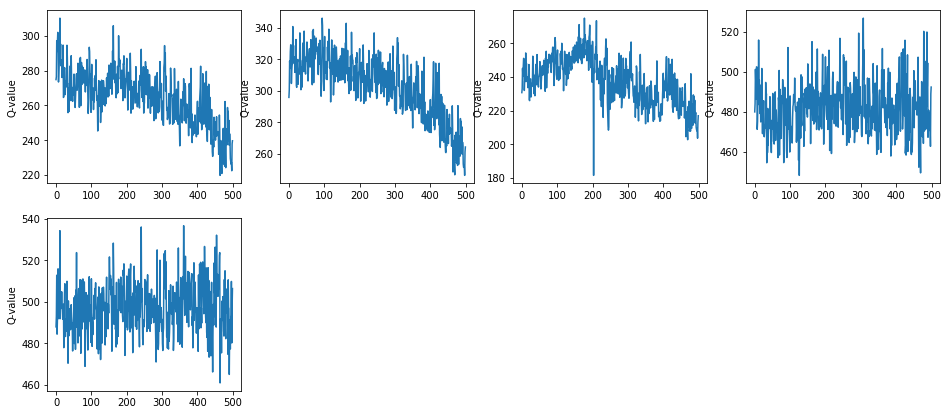

In [17]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(500))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)])[-500:])
plt.ylabel("Q-value")
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [18]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

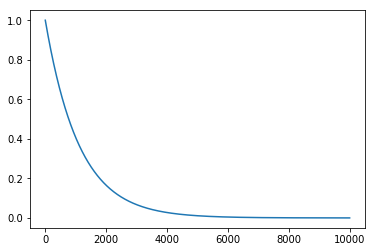

In [19]:
plt.plot(time, epsilon)
plt.show()